In [ ]:
import torchvision
import torch
import torchvision

transform_train = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])


transform_test = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# 훈련 데이터
print(train_dataset.data.shape, len(train_dataset.targets))
#print(train_dataset.targets)

# 테스트 데이터
print(test_dataset.data.shape, len(test_dataset.targets))
#print(test_dataset.targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)

print('CIFAR10 ready~')

# CUDA setting
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

(50000, 32, 32, 3) 50000
(10000, 32, 32, 3) 10000
CIFAR10 ready~
cuda


In [ ]:
from torch import nn, optim
import torchvision


net = torchvision.models.resnet34(pretrained = True)
print(net)

# in_features확인 하고 학습 돌리기
num_fc_in = net.fc.in_features
print(num_fc_in)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# fc층 구축
net.classifier = nn.Sequential(
  nn.Linear(num_fc_in, 256),
  nn.BatchNorm1d(256),
  nn.ReLU(),
  nn.Linear(256, 10)
)

In [ ]:
# net to CUDA
net.to(DEVICE)

# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()
file_name = 'pretraned_effi_b7.pth'# 학습이 진행됨에 따라 이러한 이름으로 모델이 저장되도록 설정



In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# 손실 함수 로그
train_losses = []
train_acces = []
valid_losses = []
valid_accses = []

# 100회 반복
for epoch in range(30):
  total_train_loss = 0
  total_train_batch = 0
  total_train_acc = np.array([])
  total_valid_loss = 0
  total_valid_batch = 0
  total_valid_acc = np.array([])

  # train
  net.train()
  for X, y in train_loader:
    # data to CUDA
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 전회의 backward 메서드로 계산된 경사 값을 초기화
    optimizer.zero_grad()

    # y 예측 값을 계산
    y_pred = net(X)

    # CrossEntropyLoss 계산
    loss = loss_fn(y_pred, y)

    # loss의 w를 사용한 미분 계산
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
    ans = y.cpu().numpy()

    total_train_acc = np.append(total_train_acc, np.equal(est, ans))
    total_train_loss += loss
    total_train_batch += 1

  # validataion
  net.eval()
  with torch.no_grad():
    for X, y in test_loader:
      # data to CUDA
      X, y = X.to(DEVICE), y.to(DEVICE)

      # y 예측 값을 계산
      y_pred = net(X)

      # CrossEntropyLoss 계산
      loss = loss_fn(y_pred, y)

      # Accuracy 계산
      est = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
      ans = y.cpu().numpy()

      total_valid_acc = np.append(total_valid_acc, np.equal(est, ans))
      total_valid_loss += loss
      total_valid_batch += 1
   
  print('Epoch:%03d' % (epoch + 1), '- train loss:', '{:.4f}'.format(total_train_loss/total_train_batch),
        'acc:', '{:.4f}'.format(np.mean(total_train_acc)),
        '- valid loss:', '{:.4f}'.format(total_valid_loss/total_valid_batch),
        'acc:', '{:.4f}'.format(np.mean(total_valid_acc)))

  # loss 기록
  train_losses.append(total_train_loss/total_train_batch)
  train_los = []
  for x in train_losses:
      train_los.append(x.cpu().detach())
  train_acces.append(np.mean(total_train_acc))
  valid_losses.append(total_valid_loss/total_valid_batch)
  val_los = []
  for x in valid_losses:
      val_los.append(x.cpu().detach())
  valid_accses.append(np.mean(total_valid_acc))

print('Learning finished')

Epoch:001 - train loss: 0.6806 acc: 0.8252 - valid loss: 0.1663 acc: 0.9430
Epoch:002 - train loss: 0.2493 acc: 0.9154 - valid loss: 0.1467 acc: 0.9490
Epoch:003 - train loss: 0.1922 acc: 0.9352 - valid loss: 0.1386 acc: 0.9537
Epoch:004 - train loss: 0.1661 acc: 0.9432 - valid loss: 0.1343 acc: 0.9554
Epoch:005 - train loss: 0.1453 acc: 0.9501 - valid loss: 0.1545 acc: 0.9507
Epoch:006 - train loss: 0.1356 acc: 0.9535 - valid loss: 0.1493 acc: 0.9568
Epoch:007 - train loss: 0.1236 acc: 0.9573 - valid loss: 0.1363 acc: 0.9574
Epoch:008 - train loss: 0.1211 acc: 0.9587 - valid loss: 0.1426 acc: 0.9575
Epoch:009 - train loss: 0.1121 acc: 0.9615 - valid loss: 0.1285 acc: 0.9610
Epoch:010 - train loss: 0.1031 acc: 0.9643 - valid loss: 0.1529 acc: 0.9578
Epoch:011 - train loss: 0.1031 acc: 0.9655 - valid loss: 0.1449 acc: 0.9579
Epoch:012 - train loss: 0.1023 acc: 0.9654 - valid loss: 0.1428 acc: 0.9558
Epoch:013 - train loss: 0.0920 acc: 0.9689 - valid loss: 0.1650 acc: 0.9522
Epoch:014 - 

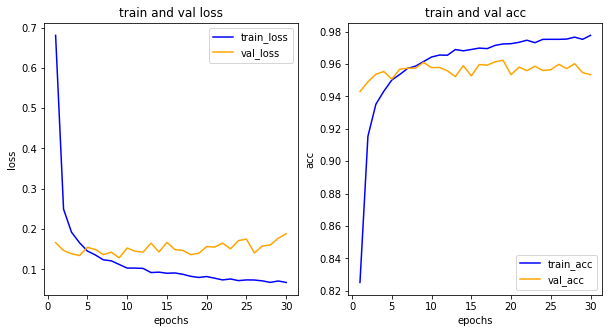

In [ ]:
# loss/acc graph 그리기
import matplotlib.pyplot as plt

epochs = range(1, len(train_los)+1)
fig = plt.figure(figsize=(10,5))

# 첫번째 열
ax1 = fig.add_subplot(1,2,1) 
ax1.plot(epochs, train_los, color ='blue', label='train_loss')
ax1.plot(epochs, val_los, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')          
ax1.legend()

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_acces, color = 'blue', label = 'train_acc')
ax2.plot(epochs, valid_accses, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

In [ ]:
PATH = '/content/Untitled Folder'

torch.save(net, PATH + 'model.pt')  # 전체 모델 저장
torch.save(net.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')

In [ ]:
model=torch.load('resnet34_model.pt')